In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import numpy as np
import pickle
import glob
import os

path_base = os.getcwd()

## Metodos de preprocesamiento

In [2]:
def process_sample_dir(sample_dir, max_img):
    image_forge = []
    image_genuine = []

    if os.path.isdir(sample_dir):
        # Forge images
        forge_path = os.path.join(sample_dir, 'forge')
        if os.path.isdir(forge_path):
            forge_imgs = glob.glob(os.path.join(forge_path, '*.jpg')) + glob.glob(os.path.join(forge_path, '*.png'))
            image_forge.extend(sorted(forge_imgs)[:max_img])  # Puedes usar random.sample(...) si deseas aleatoriedad

        # Genuine images
        genuine_path = os.path.join(sample_dir, 'genuine')
        if os.path.isdir(genuine_path):
            genuine_imgs = glob.glob(os.path.join(genuine_path, '*.jpg')) + glob.glob(os.path.join(genuine_path, '*.png'))
            image_genuine.extend(sorted(genuine_imgs)[:max_img])

    return [image_forge, image_genuine]

def read_image_from_drive_parallel(base_path: str, max_workers=8, max_sample=100, max_img=5):
    image_data = []

    sample_dirs = sorted(glob.glob(os.path.join(path_base, base_path, '*')))[:max_sample]
    sample_len = len(sample_dirs)
    print(f"{base_path} con {sample_len} muestras")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_sample_dir, d, max_img): d
            for d in sample_dirs
        }
        for i, future in enumerate(as_completed(futures)):
            print(f"\r[{i+1}/{sample_len}]", end="")
            result = future.result()
            image_data.append(result)

    print()
    return image_data


In [3]:
def load_image_matrix_grayscale(img_path, scale=(640, 480)):
    """
    Carga una imagen en escala de grises, la escala proporcionalmente 
    según el lado mayor, y la rellena centrada en un canvas blanco del tamaño `scale`.
    Devuelve una matriz 2D (alto x ancho) con valores en [0, 255].
    """
    try:
        # Abrir imagen y convertir a escala de grises
        img = Image.open(img_path).convert('L')
        original_width, original_height = img.size
        target_width, target_height = scale

        # Escalado proporcional
        ratio = min(target_width / original_width, target_height / original_height)
        new_width = int(original_width * ratio)
        new_height = int(original_height * ratio)

        # Redimensionar imagen
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)

        # Crear canvas blanco en escala de grises (255)
        canvas = Image.new('L', (target_width, target_height), color=255)
        offset_x = (target_width - new_width) // 2
        offset_y = (target_height - new_height) // 2

        # Pegar imagen escalada centrada en el canvas
        canvas.paste(img_resized, (offset_x, offset_y))

        # Devolver matriz 2D (sin canal adicional)
        return np.array(canvas)

    except Exception as e:
        print(f"\nError loading image {img_path}: {e}")
        return None

def load_images_as_matrices_parallel(path_data, max_workers=8, scale=(640, 480)):
    """
    Carga imágenes en paralelo por muestra utilizando ThreadPoolExecutor,
    aplicando escalado proporcional con padding negro a tamaño fijo.
    """
    image_data_matrices = []
    total_samples = len(path_data)

    for i, sample in enumerate(path_data):
        print(f"\rProcesando muestra [{i+1}/{total_samples}]", end="")

        forge_paths, genuine_paths = sample
        forge_matrices = []
        genuine_matrices = []

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            forge_futures = {
                executor.submit(load_image_matrix_grayscale, path, scale): path
                for path in forge_paths
            }
            for future in as_completed(forge_futures):
                img_matrix = future.result()
                if img_matrix is not None:
                    forge_matrices.append(img_matrix)

            genuine_futures = {
                executor.submit(load_image_matrix_grayscale, path, scale): path
                for path in genuine_paths
            }
            for future in as_completed(genuine_futures):
                img_matrix = future.result()
                if img_matrix is not None:
                    genuine_matrices.append(img_matrix)

        image_data_matrices.append([forge_matrices, genuine_matrices])
    print()
    return image_data_matrices

In [4]:
def export_data_to_binary(data, filename):
    """
    Exporta datos a un archivo binario usando pickle.

    data: Los datos a exportar (lista de matrices de imágenes).
    filename: Nombre del archivo binario de salida.
    """

    dir_save = os.path.join(path_base, filename)

    try:
        with open(dir_save, 'wb') as f:
            pickle.dump(data, f)
        print(f"\nDatos exportados exitosamente a '{dir_save}'")
    except Exception as e:
        print(f"\nError al exportar datos a '{dir_save}': {e}")

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def mostrar_imagen_muestra(image_data, muestra_idx=0, tipo='forge', imagen_idx=0):
    """
    Muestra una imagen específica de una muestra en image_data.
    Convierte imágenes en escala de grises (H, W) o (H, W, 1) a formato RGB (H, W, 3).

    Parámetros:
        image_data: lista con la estructura [[forge[], genuine[]], ...]
        muestra_idx: índice de la muestra (ej. 0 para la primera)
        tipo: 'forge' o 'genuine'
        imagen_idx: índice de la imagen dentro del tipo
    """
    try:
        tipo_idx = 0 if tipo == 'forge' else 1
        imagen = image_data[muestra_idx][tipo_idx][imagen_idx]

        # Asegurar forma (H, W)
        if imagen.ndim == 3 and imagen.shape[-1] == 1:
            imagen = imagen[:, :, 0]  # quitar dimensión de canal

        # Convertir a RGB duplicando valores
        if imagen.ndim == 2:
            imagen_rgb = np.stack([imagen] * 3, axis=-1)
        else:
            imagen_rgb = imagen  # ya sería RGB si llega aquí

        plt.imshow(imagen_rgb.astype(np.uint8))
        plt.axis('off')
        plt.title(f"Muestra {muestra_idx} - {tipo} #{imagen_idx}")
        plt.show()

    except IndexError:
        print("❌ Índices fuera de rango. Verifica muestra_idx e imagen_idx.")
    except Exception as e:
        print(f"❌ Error al mostrar imagen: {e}")


## Procesando Train

In [8]:
path_train = read_image_from_drive_parallel('train', max_sample=210, max_img=6)

train con 210 muestras
[210/210]


In [9]:
image_data_train = load_images_as_matrices_parallel(path_train, scale=(320, 240))

Procesando muestra [210/210]


In [14]:
export_data_to_binary(image_data_train, '210_6_train_image_matrices.pkl')


Datos exportados exitosamente a 'c:\Users\darkcry\Downloads\data\210_6_train_image_matrices.pkl'


In [15]:
np_image_data_train = np.array(image_data_train)

In [16]:
np_image_data_train.shape

(210, 2, 6, 240, 320)

In [ ]:
export_data_to_binary(np_image_data_train, 'np_train_image_matrices.pkl')

## Procesando Test

In [24]:
path_test = read_image_from_drive_parallel('test', max_sample=150, max_img=4)

test con 150 muestras
[150/150]


In [25]:
image_data_test = load_images_as_matrices_parallel(path_test, scale=(320, 240))

Procesando muestra [150/150]


In [ ]:
export_data_to_binary(image_data_test, '2150_4_test_image_matrices.pkl')


Datos exportados exitosamente a 'c:\Users\darkcry\Downloads\data\210_test_image_matrices.pkl'


In [16]:
np_image_data_test = np.array(image_data_test)

In [17]:
np_image_data_test.shape

(50, 2, 4, 240, 320)

In [ ]:
export_data_to_binary(np_image_data_test, 'np_test_image_matrices.pkl')

## Ploteo

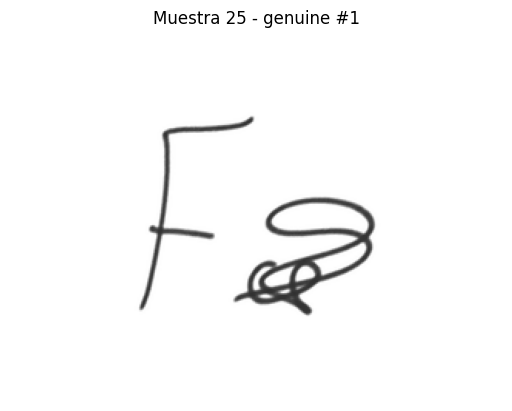

In [13]:
mostrar_imagen_muestra(image_data_train, muestra_idx=25, tipo='genuine', imagen_idx=1)

🔹 Imagen original (2D):
[[  0 127 255]
 [ 60 100 200]
 [ 30  90 180]]
Shape: (3, 3)

🔸 Imagen con canal expandido (3D):
[[[  0]
  [127]
  [255]]

 [[ 60]
  [100]
  [200]]

 [[ 30]
  [ 90]
  [180]]]
Shape: (3, 3, 1)


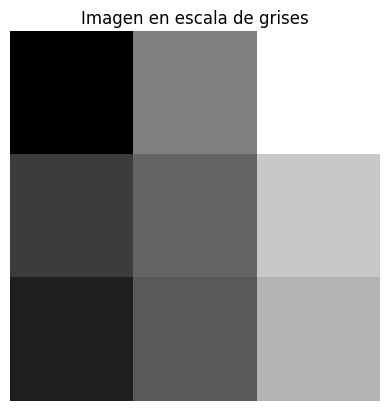

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Crear una imagen de ejemplo en escala de grises de 3x3 (matriz 2D)
img_gray = np.array([
    [0, 127, 255],
    [60, 100, 200],
    [30, 90, 180]
], dtype=np.uint8)

print("🔹 Imagen original (2D):")
print(img_gray)
print("Shape:", img_gray.shape)  # (3, 3)

# Expandir la dimensión del canal (convierte a 3D)
img_expanded = np.expand_dims(img_gray, axis=-1)  # o img_gray[..., np.newaxis]

print("\n🔸 Imagen con canal expandido (3D):")
print(img_expanded)
print("Shape:", img_expanded.shape)  # (3, 3, 1)

# Visualizar con matplotlib (capa 0)
plt.imshow(img_expanded[:, :, 0], cmap='gray')
plt.title("Imagen en escala de grises")
plt.axis('off')
plt.show()
